In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
#     -O /tmp/sarcasm.json

In [3]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [4]:
with open("./tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
_________________________________________________________________


In [7]:
import numpy as np

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Train on 20000 samples, validate on 6709 samples
Epoch 1/50
20000/20000 [==============================] - 4s 193us/sample - loss: 0.4661 - accuracy: 0.7673 - val_loss: 0.4028 - val_accuracy: 0.8152
Epoch 2/50
20000/20000 [==============================] - 3s 172us/sample - loss: 0.3521 - accuracy: 0.8432 - val_loss: 0.3887 - val_accuracy: 0.8213
Epoch 3/50
20000/20000 [==============================] - 4s 184us/sample - loss: 0.3151 - accuracy: 0.8630 - val_loss: 0.3904 - val_accuracy: 0.8210
Epoch 4/50
20000/20000 [==============================] - 4s 177us/sample - loss: 0.2817 - accuracy: 0.8795 - val_loss: 0.4075 - val_accuracy: 0.8201
Epoch 5/50
20000/20000 [==============================] - 4s 192us/sample - loss: 0.2524 - accuracy: 0.8931 - val_loss: 0.4330 - val_accuracy: 0.8186
Epoch 6/50
20000/20000 [==============================] - 3s 171us/sample - loss: 0.2194 - accuracy: 0.9125 - val_loss: 0.4546 - val_accuracy: 0.8150
Epoch 7/50
20000/20000 [===========================

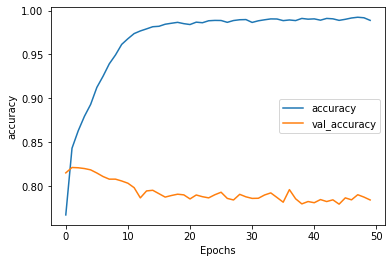

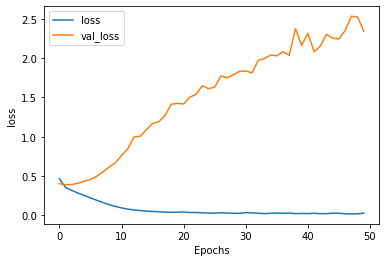

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [9]:
model.save("test.h5")